# Temporal SIR

In [68]:
import time
import numpy as np
import torch

from sbi import utils as utils
from sbi import analysis as analysis
from cost_aware_snpe_c import CostAwareSNPE_C
from sbi.inference.snpe.snpe_c import SNPE_C
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from simulators import temporal_sir

from hydra import compose, initialize
import hydra

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt
import seaborn as sns

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
cfg = compose(config_name="train")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    'font.family' : 'times',
    'font.size' : 14.0,
    'lines.linewidth' : 2,
    'lines.antialiased' : True,
    'axes.facecolor': 'fdfdfd',
    'axes.edgecolor': '777777',
    'axes.linewidth' : 1,
    'axes.titlesize' : 'medium',
    'axes.labelsize' : 'medium',
    'axes.axisbelow' : True,
    'xtick.major.size'     : 0,      # major tick size in points
    'xtick.minor.size'     : 0,      # minor tick size in points
    'xtick.major.pad'      : 6,      # distance to major tick label in points
    'xtick.minor.pad'      : 6,      # distance to the minor tick label in points
    'xtick.color'          : '333333', # color of the tick labels
    'xtick.labelsize'      : 'medium', # fontsize of the tick labels
    'xtick.direction'      : 'in',     # direction: in or out
    'ytick.major.size'     : 0,      # major tick size in points
    'ytick.minor.size'     : 0,      # minor tick size in points
    'ytick.major.pad'      : 6,      # distance to major tick label in points
    'ytick.minor.pad'      : 6,      # distance to the minor tick label in points
    'ytick.color'          : '333333', # color of the tick labels
    'ytick.labelsize'      : 'medium', # fontsize of the tick labels
    'ytick.direction'      : 'in',     # direction: in or out
    'axes.grid' : False,
    'grid.alpha' : 0.3,
    'grid.linewidth' : 1,
    'legend.fancybox' : True,
    'legend.fontsize' : 'Small',
    'figure.figsize' : (2.5, 2.5),
    'figure.facecolor' : '1.0',
    'figure.edgecolor' : '0.5',
    'hatch.linewidth' : 0.1,
    'text.usetex' : False
    })

color_map = {'green': '#009E60', 'orange': '#C04000',
              'blue': '#00416A', 'black':'#3A3B3C',
              'purple': '#843B62', 'red': '#C41E3A'}


plt.rcParams['text.latex.preamble'] = r'\usepackage{serif}'

In [70]:
def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    m = x.shape[0]
    n = y.shape[0]

    z = torch.cat((x, y), dim=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * torch.sum(kxx) - (2 / (m * n)) * torch.sum(kxy) + (1 / n ** 2) * torch.sum(kyy)


def median_heuristic(y):
    a = torch.cdist(y, y)**2
    return torch.sqrt(torch.median(a / 2))


def kernel_matrix(x, y, l):
    d = torch.cdist(x, y)**2

    kernel = torch.exp(-(1 / (2 * l ** 2)) * d)

    return kernel

In [71]:
def calc_acc_prob(gp, likelihood, theta, prior_start, k):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        cost = likelihood(model(theta)).mean

        lower_cost = likelihood(model(prior_start)).mean
    return (lower_cost ** k) / (cost**k)

class GP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [72]:
temp_sir = temporal_sir.TemporalSIR()

## data generation

In [73]:
# DON'T NEED TO RUN
N = 50000

temp_sir_theta_npe_large = temp_sir.sample_theta([N]).reshape(-1, temp_sir.theta_dim)
temp_sir_x_npe_large = torch.empty([N, temp_sir.x_dim])
for i in range(N):
    temp_sir_x_npe_large[i, :] = temp_sir(temp_sir_theta_npe_large[i])

torch.save(temp_sir_x_npe_large, "data/temp_sir_x_npe_large.pt")
torch.save(temp_sir_theta_npe_large, "data/temp_sir_theta_npe_large.pt")

In [182]:
# DON'T NEED TO RUN
temp_sir_obs_theta = torch.tensor([0.5, 0.5])
temp_sir_obs_x = temp_sir(temp_sir_obs_theta)
temp_sir_obs_x

tensor([  2.0000,   2.0000,   3.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          1.0000,   2.0000,   5.0000,  15.0000, 116.4945])

In [37]:
# DON'T NEED TO RUN
torch.save(temp_sir_obs_x, "data/temp_sir_obs_x.pt")
torch.save(temp_sir_obs_theta, "data/temp_sir_obs_theta.pt")

## Load data

In [74]:
temp_sir_x_npe_large = torch.load("data/temp_sir_x_npe_large.pt")
temp_sir_theta_npe_large = torch.load("data/temp_sir_theta_npe_large.pt")

temp_sir_obs_x = torch.load("data/temp_sir_obs_x.pt")
temp_sir_obs_theta = torch.load("data/temp_sir_obs_theta.pt")

## Fit GP

In [78]:
# for gp
n_train_pair = 200
X = temp_sir_theta_npe_large[:n_train_pair]
n_rep = 20

times_train = torch.zeros(n_train_pair)

for i in range(n_train_pair):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(temp_sir_theta_npe_large[i])
    et = time.time()
    times_train[i] = et - st

In [123]:
# save GP training samples
torch.save(X, "data/temp_sir_gp_x.pt")
torch.save(times_train, "data/temp_sir_gp_y.pt")

In [79]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X.float())
    loss = -mll(output, times_train)
    loss.backward()
    optimizer.step()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item()}')


torch.save({
    'model_state_dict': model.state_dict(),
    'likelihood_state_dict': likelihood.state_dict()
}, 'data/temp_sir_gp.pth')


Iter 1/100 - Loss: 0.7927663922309875
Iter 2/100 - Loss: 0.7572920322418213
Iter 3/100 - Loss: 0.7212674617767334
Iter 4/100 - Loss: 0.6845076084136963
Iter 5/100 - Loss: 0.6471409797668457
Iter 6/100 - Loss: 0.6093096733093262
Iter 7/100 - Loss: 0.5711219906806946
Iter 8/100 - Loss: 0.5325443148612976
Iter 9/100 - Loss: 0.49345675110816956
Iter 10/100 - Loss: 0.4538450539112091
Iter 11/100 - Loss: 0.41375210881233215
Iter 12/100 - Loss: 0.37314510345458984
Iter 13/100 - Loss: 0.33197879791259766
Iter 14/100 - Loss: 0.29035645723342896
Iter 15/100 - Loss: 0.248462975025177
Iter 16/100 - Loss: 0.20642486214637756
Iter 17/100 - Loss: 0.16426323354244232
Iter 18/100 - Loss: 0.1219952404499054
Iter 19/100 - Loss: 0.07968887686729431
Iter 20/100 - Loss: 0.03739463910460472
Iter 21/100 - Loss: -0.004891510121524334
Iter 22/100 - Loss: -0.04715270921587944
Iter 23/100 - Loss: -0.08929107338190079
Iter 24/100 - Loss: -0.13118186593055725
Iter 25/100 - Loss: -0.17273834347724915
Iter 26/100 - L

In [84]:
model.eval()
likelihood.eval()

N = 100

beta = torch.linspace(0.1, 1, N)
beta_fixed = 1


gamma_fixed = 0.1
gamma = torch.linspace(0.1, 1, N)

beta_fixed_combined = beta_fixed * torch.ones_like(gamma)
combination_beta_fixed_gamma = torch.stack((beta_fixed_combined, gamma), dim=1)

gamma_fixed_combined = gamma_fixed * torch.ones_like(beta)
combination_beta_gamma_fixed = torch.stack((beta, gamma_fixed_combined), dim=1)

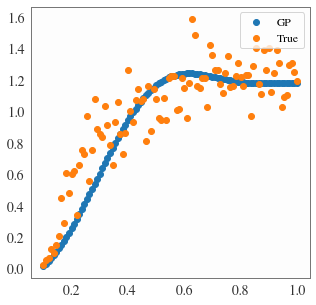

In [85]:
times_vs_beta = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(combination_beta_gamma_fixed[i])
    et = time.time()
    times_vs_beta[i] = (et - st)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(combination_beta_gamma_fixed)).mean

plt.figure(figsize=[5,5])
plt.scatter(beta, observed_pred, label="GP")
plt.scatter(beta, times_vs_beta, label="True")
plt.legend()
plt.show()

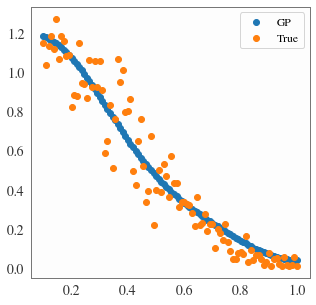

In [86]:
times_vs_gamma = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(combination_beta_fixed_gamma[i])
    et = time.time()
    times_vs_gamma[i] = (et - st)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(combination_beta_fixed_gamma)).mean

plt.figure(figsize=[5,5])
plt.scatter(gamma, observed_pred, label="GP")
plt.scatter(gamma, times_vs_gamma, label="True")
plt.legend()
plt.show()

In [124]:
state_dicts = torch.load('data/temp_sir_gp.pth')

X = torch.load("data/temp_sir_gp_x.pt")
times_train = torch.load("data/temp_sir_gp_y.pt")

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)

model.load_state_dict(state_dicts['model_state_dict'])
likelihood.load_state_dict(state_dicts['likelihood_state_dict'])

model.eval()
likelihood.eval()

prior_start = torch.tensor([0.1, 1.0]).reshape(-1, 2)
k = 1

num_sim = 5000
theta_tilde = torch.zeros([num_sim, 2])
count = 0
while count < num_sim:
    theta = temp_sir.sample_theta([1]).reshape(-1, 2)
    if calc_acc_prob(model, likelihood, theta, prior_start, k) > torch.rand(1):
        theta_tilde[count] = theta.reshape(-1)
        count += 1

In [125]:
w = likelihood(model(theta_tilde)).mean.detach() ** k

In [126]:
theta_prior = temp_sir.sample_theta([5000]).reshape(-1, 2)

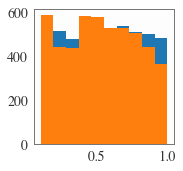

In [127]:
plt.hist(theta_prior.detach().numpy()[:, 0], bins=10)
plt.hist(theta_tilde.detach().numpy()[:, 0], bins=10)
plt.show()

In [128]:
likelihood(model(torch.tensor([0.1, 1.0]).reshape(1, 2))).mean

tensor([0.0494], grad_fn=<ViewBackward0>)

In [129]:
likelihood(model(torch.tensor([0.5, 0.1]).reshape(1, 2))).mean

tensor([1.1662], grad_fn=<ViewBackward0>)

## Train

In [102]:
# DON'T NEED TO RUN
temp_sir_inference_npe_large = SNPE_C()
temp_sir_nn_npe_large = temp_sir_inference_npe_large.append_simulations(
    temp_sir_theta_npe_large, temp_sir_x_npe_large).train()

/Users/huangd5/anaconda3/lib/python3.9/site-packages/sbi/utils/sbiutils.py:55: UserWarning: Z-scoring these simulation outputs resulted in {num_unique_z} unique
                datapoints. Before z-scoring, it had been {num_unique}. This can occur 
                due to numerical inaccuracies when the data covers a large range of 
                values. Consider either setting `z_score_x=False` (but beware that this 
                can be problematic for training the NN) or exclude outliers from your 
                dataset. Note: if you have already set `z_score_x=False`, this warning
                will still be displayed, but you can ignore it.
  warnings.warn(


 Neural network successfully converged after 78 epochs.

In [183]:
# DON'T NEED TO RUN
prior, *_ = process_prior(temp_sir.prior)

temp_sir_post_npe_large = temp_sir_inference_npe_large.build_posterior(temp_sir_nn_npe_large, prior=prior)
temp_sir_samples_npe_large = temp_sir_post_npe_large.sample((1000,), x=temp_sir_obs_x)

/Users/huangd5/anaconda3/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 2 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/Users/huangd5/anaconda3/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [184]:
# DON'T NEED TO RUN
torch.save(temp_sir_samples_npe_large, "data/temp_sir_post_reference.pt")

In [185]:
temp_sir_post_reference = torch.load("data/temp_sir_post_reference.pt")

In [188]:
k = 0.5
n_run = 50
mmd_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 2])
cost_npe = torch.zeros([n_run])
mmd_canpe = torch.zeros([n_run])
posterior_samples_canpe = torch.zeros([n_run, 1000, 2])
cost_canpe = torch.zeros([n_run])

cost_saved = torch.zeros([n_run])

for i in range(n_run):
    checkpoint_path = f"sims/temp_sir/{k}/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    posterior_npe = checkpoint["posterior_npe"]
    posterior_canpe = checkpoint["posterior_canpe"]
    

#     posterior_samples_npe[i] = checkpoint["posterior_samples_npe"]
#     posterior_samples_canpe[i] = checkpoint["posterior_samples_canpe"]
    
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
    posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
    
    mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))
    mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))
    cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
    cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
    
    cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
    
mmd_npe = mmd_npe.detach().numpy() 
mmd_npe_mean = np.mean(mmd_npe)
mmd_npe_std = np.std(mmd_npe)

mmd_canpe = mmd_canpe.detach().numpy() 
mmd_canpe_mean = np.mean(mmd_canpe)
mmd_canpe_std = np.std(mmd_canpe)

cost_npe = cost_npe.detach().numpy() 
cost_npe_mean = np.mean(cost_npe)
cost_npe_std = np.std(cost_npe)

cost_canpe = cost_canpe.detach().numpy() 
cost_canpe_mean = np.mean(cost_canpe)
cost_canpe_std = np.std(cost_canpe)

cost_saved = cost_saved.detach().numpy()
cost_saved_mean = np.mean(cost_saved)
cost_saved_std = np.std(cost_saved)

print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")
print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")

print(f"NPE cost mean {cost_npe_mean:.2f} (std {cost_npe_std:.2f})")
print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")

print(f"Cost saved: {cost_saved_mean}(std {cost_saved_std})")

NPE MMD mean 0.02 (std 0.01)
CA-NPE MMD mean 0.03 (std 0.01)
NPE cost mean 537.92 (std 65.20)
CA-NPE cost mean 342.77 (std 33.99)
Cost saved: 0.36035996675491333(std 0.03769451379776001)


In [192]:
k = 1.0
n_run = 50
mmd_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 2])
cost_npe = torch.zeros([n_run])
mmd_canpe = torch.zeros([n_run])
posterior_samples_canpe = torch.zeros([n_run, 1000, 2])
cost_canpe = torch.zeros([n_run])

cost_saved = torch.zeros([n_run])


for i in range(n_run):
    checkpoint_path = f"sims/temp_sir/{k}/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    posterior_npe = checkpoint["posterior_npe"]
    posterior_canpe = checkpoint["posterior_canpe"]
    

#     posterior_samples_npe[i] = checkpoint["posterior_samples_npe"]
#     posterior_samples_canpe[i] = checkpoint["posterior_samples_canpe"]
    
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
    posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
    
    mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))
    mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))
    cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
    cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
    
    cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
    
mmd_npe = mmd_npe.detach().numpy() 
mmd_npe_mean = np.mean(mmd_npe)
mmd_npe_std = np.std(mmd_npe)

mmd_canpe = mmd_canpe.detach().numpy() 
mmd_canpe_mean = np.mean(mmd_canpe)
mmd_canpe_std = np.std(mmd_canpe)

cost_npe = cost_npe.detach().numpy() 
cost_npe_mean = np.mean(cost_npe)
cost_npe_std = np.std(cost_npe)

cost_canpe = cost_canpe.detach().numpy() 
cost_canpe_mean = np.mean(cost_canpe)
cost_canpe_std = np.std(cost_canpe)

cost_saved = cost_saved.detach().numpy()
cost_saved_mean = np.mean(cost_saved)
cost_saved_std = np.std(cost_saved)

print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")
print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")

print(f"NPE cost mean {cost_npe_mean:.2f} (std {cost_npe_std:.2f})")
print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")

print(f"Cost saved: {cost_saved_mean}(std {cost_saved_std})")

NPE MMD mean 0.02 (std 0.01)
CA-NPE MMD mean 0.05 (std 0.01)
NPE cost mean 494.84 (std 96.63)
CA-NPE cost mean 170.36 (std 28.13)
Cost saved: 0.653033971786499(std 0.01951533369719982)


In [195]:
k = 2.0
n_run = 100
mmd_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 2])
cost_npe = torch.zeros([n_run])
mmd_canpe = torch.zeros([n_run])
posterior_samples_canpe = torch.zeros([n_run, 1000, 2])
cost_canpe = torch.zeros([n_run])

cost_saved = torch.zeros([n_run])


for i in range(n_run):
    checkpoint_path = f"sims/temp_sir/{k}/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    posterior_npe = checkpoint["posterior_npe"]
    posterior_canpe = checkpoint["posterior_canpe"]
    

#     posterior_samples_npe[i] = checkpoint["posterior_samples_npe"]
#     posterior_samples_canpe[i] = checkpoint["posterior_samples_canpe"]
    
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
    posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
    
    mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))
    mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))
    cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
    cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
    
    cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
    
mmd_npe = mmd_npe.detach().numpy() 
mmd_npe_mean = np.mean(mmd_npe)
mmd_npe_std = np.std(mmd_npe)

mmd_canpe = mmd_canpe.detach().numpy() 
mmd_canpe_mean = np.mean(mmd_canpe)
mmd_canpe_std = np.std(mmd_canpe)

cost_npe = cost_npe.detach().numpy() 
cost_npe_mean = np.mean(cost_npe)
cost_npe_std = np.std(cost_npe)

cost_canpe = cost_canpe.detach().numpy() 
cost_canpe_mean = np.mean(cost_canpe)
cost_canpe_std = np.std(cost_canpe)

cost_saved = cost_saved.detach().numpy()
cost_saved_mean = np.mean(cost_saved)
cost_saved_std = np.std(cost_saved)

print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")
print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")

print(f"NPE cost mean {cost_npe_mean:.2f} (std {cost_npe_std:.2f})")
print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")

print(f"Cost saved: {cost_saved_mean}(std {cost_saved_std})")

NPE MMD mean 0.02 (std 0.01)
CA-NPE MMD mean 0.05 (std 0.02)
NPE cost mean 446.10 (std 119.01)
CA-NPE cost mean 65.36 (std 13.42)
Cost saved: 0.8509341478347778(std 0.012751813046634197)


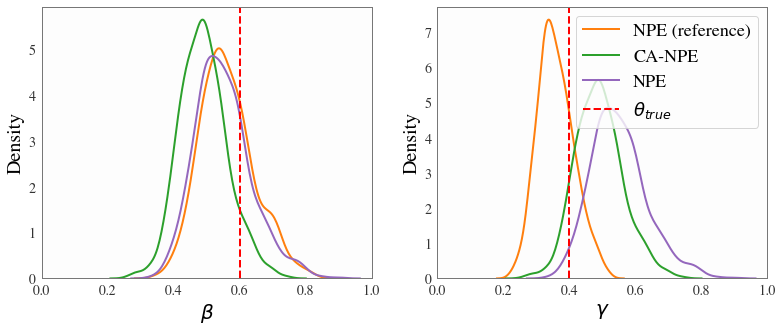

In [147]:
seed = 4
plt.figure(figsize=[13,5])
plt.subplot(1, 2, 1)
plt.xlim(0, 1)
sns.kdeplot(temp_sir_post_reference[:,0], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,0], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,0], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=temp_sir_obs_theta.detach().numpy()[0], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')

plt.xlabel("$\\beta$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
# plt.title(f"MMD:{mmd[seed]:.2f}")

plt.subplot(1, 2, 2)
plt.xlim(0, 1)
sns.kdeplot(temp_sir_post_reference[:,1], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,0], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,0], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=temp_sir_obs_theta.detach().numpy()[1], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.legend(fontsize=18, loc=1)
plt.xlabel("$\\gamma$", fontsize = 20)
plt.ylabel("Density", fontsize=20)

plt.show()

In [158]:
temp_sir_obs_x.shape

torch.Size([12])

In [170]:
temp_sir_post_npe_large.log_prob(theta=temp_sir_post_reference[1:3].reshape(2,2), x=temp_sir_obs_x.reshape(1, -1))

tensor([3.5765, 4.6044])

# Figure 1

In [178]:
N = 20
n_rep = 50

beta_range = np.linspace(0, 1, N)
gamma_range = np.linspace(0, 1, N)

beta_grid, gamma_grid = np.meshgrid(beta_range, gamma_range)
theta_grid = np.hstack((beta_grid.reshape(-1, 1), gamma_grid.reshape(-1, 1)))

cost_real = np.zeros([N, N])

In [179]:
for i in range(N):
    for j in range(N):
        st = time.time()
        for _ in range(n_rep):
            result = temp_sir(torch.tensor([beta_range[i], gamma_range[j]]))
        et = time.time()
        cost_real[i, j] = (et - st) / n_rep
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [180]:
np.save("cost.npy", cost_real)

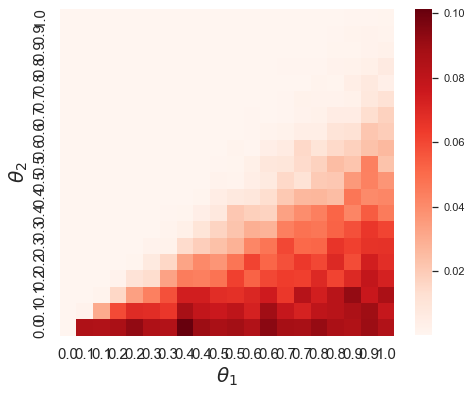

In [181]:
beta_range = np.linspace(0, 1, N)
gamma_range = np.linspace(0, 1, N)
sns.set(style="white")

plt.figure(figsize=(7.5, 6))
sns.heatmap(cost_real.T, xticklabels=np.round(beta_range, 1), yticklabels=np.round(gamma_range, 1), annot=False, fmt=".2f", cmap='Reds').invert_yaxis()
# plt.title('Cost Heatmap by $\\beta$ and $\\gamma$', size=25)
plt.xlabel('$\\theta_1$', size=20)
plt.ylabel('$\\theta_2$', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()